In [1]:
# rm(list=ls())

# OS and home pointer
os <- ifelse(Sys.info()["sysname"]=="Linux","/home/j/", ifelse(Sys.info()["sysname"]=="Darwin", "~/j","J:/"))
home <- ifelse(Sys.info()["sysname"]=="Linux","/homes/sadatnfs/", ifelse(Sys.info()["sysname"]=="Darwin", "~/h","H:/"))

require(foreign)
require(ggplot2)
require(grid)
require(reshape2)
require(dplyr)
require(data.table)
require(MASS)
# Using personal R library for some missing packages in the cluster
if(Sys.info()["sysname"]=="Linux") {
    libloc = paste0(home,"R/x86_64-unknown-linux-gnu-library/3.1")
    require(readstata13, lib.loc = libloc)
    require(feather, lib.loc = libloc)
    require(gridExtra, lib.loc = libloc)
    require(VineCopula, lib.loc = libloc)
    require(copula, lib.loc = libloc)
    require("forecast", lib.loc = libloc)
}
# else use default R
if(Sys.info()["sysname"]=="Windows") {
    require(readstata13)
    require(feather)
    require(gridExtra)
    require(VineCopula)
    require(copula)
}




## Resizing notebook plot space
options(repr.plot.width=16, repr.plot.height=9)

Loading required package: foreign
Loading required package: ggplot2
Loading required package: grid
Loading required package: reshape2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: data.table
------------------------------------------------------------------------------
data.table + dplyr code now lives in dtplyr.
Please library(dtplyr)!
------------------------------------------------------------------------------

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following objects are masked from ‘package:reshape2’:

    dcast, melt

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: readstata13
Loading required 

In [2]:
pop <- fread('/ihme/forecasting/data/fbd_pop/best/agg/pop_draws_upload.csv')

Read 632808 rows and 1004 (of 1004) columns from 7.398 GB file in 00:02:14


In [3]:
unique(pop[,year_id])
head(pop)

[1] 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
[16] 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
[31] 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034
[46] 2035 2036 2037 2038 2039 2040

age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,⋯,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,location_id,sex_id,year_id
1,66002653,66002653,66002653,66002653,66002653,66002653,66002653,66002653,66002653,⋯,66002653,66002653,66002653,66002653,66002653,66002653,66002653,6,1,1990
1,66171302,66171302,66171302,66171302,66171302,66171302,66171302,66171302,66171302,⋯,66171302,66171302,66171302,66171302,66171302,66171302,66171302,6,1,1991
1,65273100,65273100,65273100,65273100,65273100,65273100,65273100,65273100,65273100,⋯,65273100,65273100,65273100,65273100,65273100,65273100,65273100,6,1,1992
1,63429381,63429381,63429381,63429381,63429381,63429381,63429381,63429381,63429381,⋯,63429381,63429381,63429381,63429381,63429381,63429381,63429381,6,1,1993
1,60856239,60856239,60856239,60856239,60856239,60856239,60856239,60856239,60856239,⋯,60856239,60856239,60856239,60856239,60856239,60856239,60856239,6,1,1994
1,57785389,57785389,57785389,57785389,57785389,57785389,57785389,57785389,57785389,⋯,57785389,57785389,57785389,57785389,57785389,57785389,57785389,6,1,1995


In [2]:
set.seed(123)
draws <- read.csv(paste0(os,"/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/gpr_draws_country_year_collapsed.csv"))
colnames(draws) <- c("X", "location_id", "year_id", paste0("draw_", c(1:1000)))

In [3]:
setwd(paste0(os, "/temp/central_comp/libraries/current/r"))
source("get_location_metadata.R")
loc <- get_location_metadata("22")
loc <- loc[, .(location_id, ihme_loc_id)]

In [4]:
# Merge ihme_loc_id to draws
draws_loc <- merge(draws, loc, by="location_id", all.x=T)
draws_loc$X <- NULL

In [5]:
# Number of draws
N_draws <- 1000

# Number of offseting variables before the draws (location_id, year_id)
offset_vars <- 3

# Subset a country of choice
isoiso <- "CHN"

# Create a DF of just the country above
country_sub <- subset(draws_loc, ihme_loc_id==paste0(isoiso) )[,1:(N_draws + offset_vars)]

# cbind(country_sub[, c("location_id", "year_id")], 
#                      rowMeans(country_sub[, grep(glob2rx("draw_*"), names(country_sub))], na.rm = TRUE, dims = 1), 
#                      t(apply(country_sub[, grep(glob2rx("draw_*"), names(country_sub))],1,quantile,probs=c(0.025, 0.975),na.rm=TRUE)))

In [9]:
# Transpose draws to long and year to wide
melt1 <- melt(country_sub, id.vars = c("location_id", "ihme_loc_id", "year_id"))
dcast1 <- dcast(melt1, ihme_loc_id + location_id  + variable ~   year_id, value.var="value")

In [10]:
# Baseline RHO: Compute correlation for each pairs of year from 1950 to 2015? (country specific)
baseline_rho <- function(data, yr1, yr2) {

    rho <- vector()
    j = 0
    for(i in yr1:yr2) {
      j = j + 1
      rho[j] = cor(x = data[,paste0(i)], y = data[,paste0(i+1)], method = "spearman")
    }

        return(rho)
    }
mean_rho <- baseline_rho(dcast1, 1950,2015)

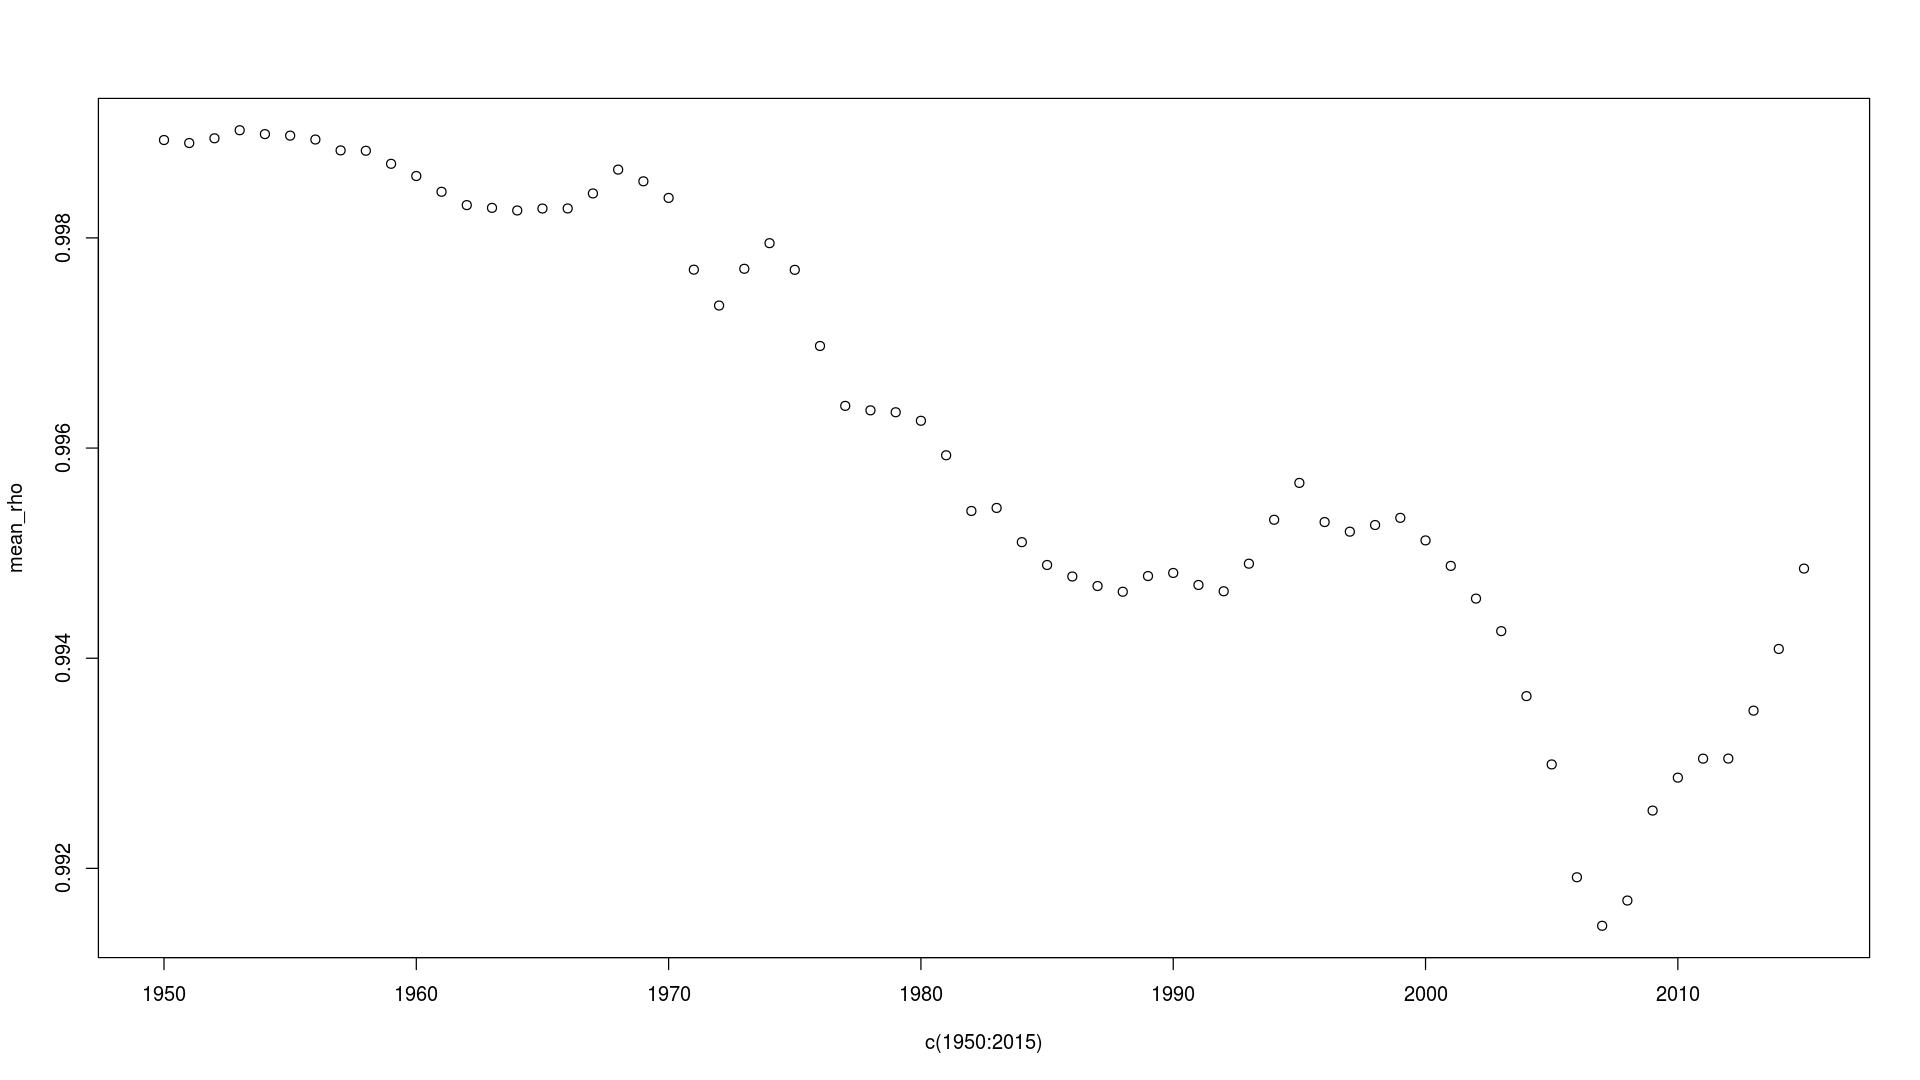

In [11]:
plot(c(1950:2015),mean_rho)

In [12]:
# Year to be sorted relative to baseline year
y1_vect <- c(2016:2040)

# Baseline year
# y2_vect <- c(2015:2039)

In [13]:
post_copula <- dcast1 
post_copula <- arrange(post_copula, `2015`)

In [14]:
head(post_copula)

ihme_loc_id,location_id,variable,1950,1951,1952,1953,1954,1955,1956,⋯,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
CHN,6,draw_360,2.462830,2.514532,2.569471,2.627734,2.689313,2.754220,2.823144,⋯,10.048653,10.154221,10.25898,10.36264,10.46495,10.56609,10.66608,10.76482,10.86230,10.95855
CHN,6,draw_662,2.565150,2.650861,2.741553,2.836509,2.934617,3.034935,3.137251,⋯,9.910074,9.997352,10.08603,10.17628,10.26829,10.37058,10.47682,10.58703,10.70118,10.81913
CHN,6,draw_47,2.613746,2.701729,2.791767,2.883184,2.975116,3.067153,3.160532,⋯,9.837625,9.929743,10.02390,10.12023,10.21888,10.32331,10.43218,10.54566,10.66388,10.78686
CHN,6,draw_635,2.331153,2.400071,2.473097,2.549946,2.630376,2.714332,2.802121,⋯,10.182041,10.281885,10.37928,10.47397,10.56572,10.66099,10.75316,10.84204,10.92754,11.00958
CHN,6,draw_145,2.596049,2.690654,2.789666,2.892676,2.998963,3.107920,3.219815,⋯,10.184820,10.277226,10.37115,10.46700,10.56515,10.66554,10.76785,10.87225,10.97889,11.08784
CHN,6,draw_413,2.716696,2.792401,2.870403,2.949652,3.029047,3.108023,3.187298,⋯,10.469812,10.595522,10.72043,10.84426,10.96673,11.07744,11.18462,11.28810,11.38775,11.48346


### Using Neal's function

In [11]:
cop_sort_data <- function(X, corr){
  if(length(corr) == 1){
    corr <- matrix(data=corr, nrow=ncol(X), ncol=ncol(X))
    diag(corr) <- 1
  }
  mvdat <- mvrnorm(n=nrow(X), mu=0 * 1:ncol(X), Sigma=corr, empirical=T)
  ranks <- apply(mvdat, 2, rank, ties.method="first")
  sorted_X <- apply(X, 2, sort)
  sapply(1:ncol(X), function(x) sorted_X[,x][ranks[,x]])
}

In [62]:
# Testing Neal's function
neal_cop <- post_copula[,c("location_id", "ihme_loc_id", "variable")]
new_post<-data.frame(cop_sort_data(post_copula[, 4:94], mean_rho))
neal_cop <- cbind(neal_cop, new_post)
colnames(neal_cop) <- c("location_id", "ihme_loc_id", "variable", paste0(c(1950:2040)))

#### Reshape properly

In [74]:
t1 <- melt(neal_cop, id.vars = c("location_id", "ihme_loc_id", "variable"), value.name = "edu")
colnames(t1) <- c("location_id", "ihme_loc_id", "draw", "year_id", "edu")
neal_cop_proper <- dcast(t1, value.var = "edu", location_id + ihme_loc_id + year_id ~ draw)

t1 <- melt(post_copula, id.vars = c("location_id", "ihme_loc_id", "variable"), value.name = "edu")
colnames(t1) <- c("location_id", "ihme_loc_id", "draw", "year_id", "edu")
pre_cop_proper <- dcast(t1, value.var = "edu", location_id + ihme_loc_id + year_id ~ draw)

In [75]:
## Vector of random draws
samp_colnames <- c("ihme_loc_id", "year_id", paste0("draw_",sample(N_draws, size = 15)))

## Subset out each of the 
melt_pre <- pre_cop_proper[,samp_colnames]

## Post copula data
melt_post <- neal_cop_proper[,samp_colnames]

## Melt the data post-sampling
melt_pre <- melt(melt_pre, id.vars = c("ihme_loc_id", "year_id"), value.name = "edu")
melt_pre$year <- as.numeric(melt_pre$year) + 2015
melt_post <- melt(melt_post, id.vars = c("ihme_loc_id", "year_id"), value.name = "edu")


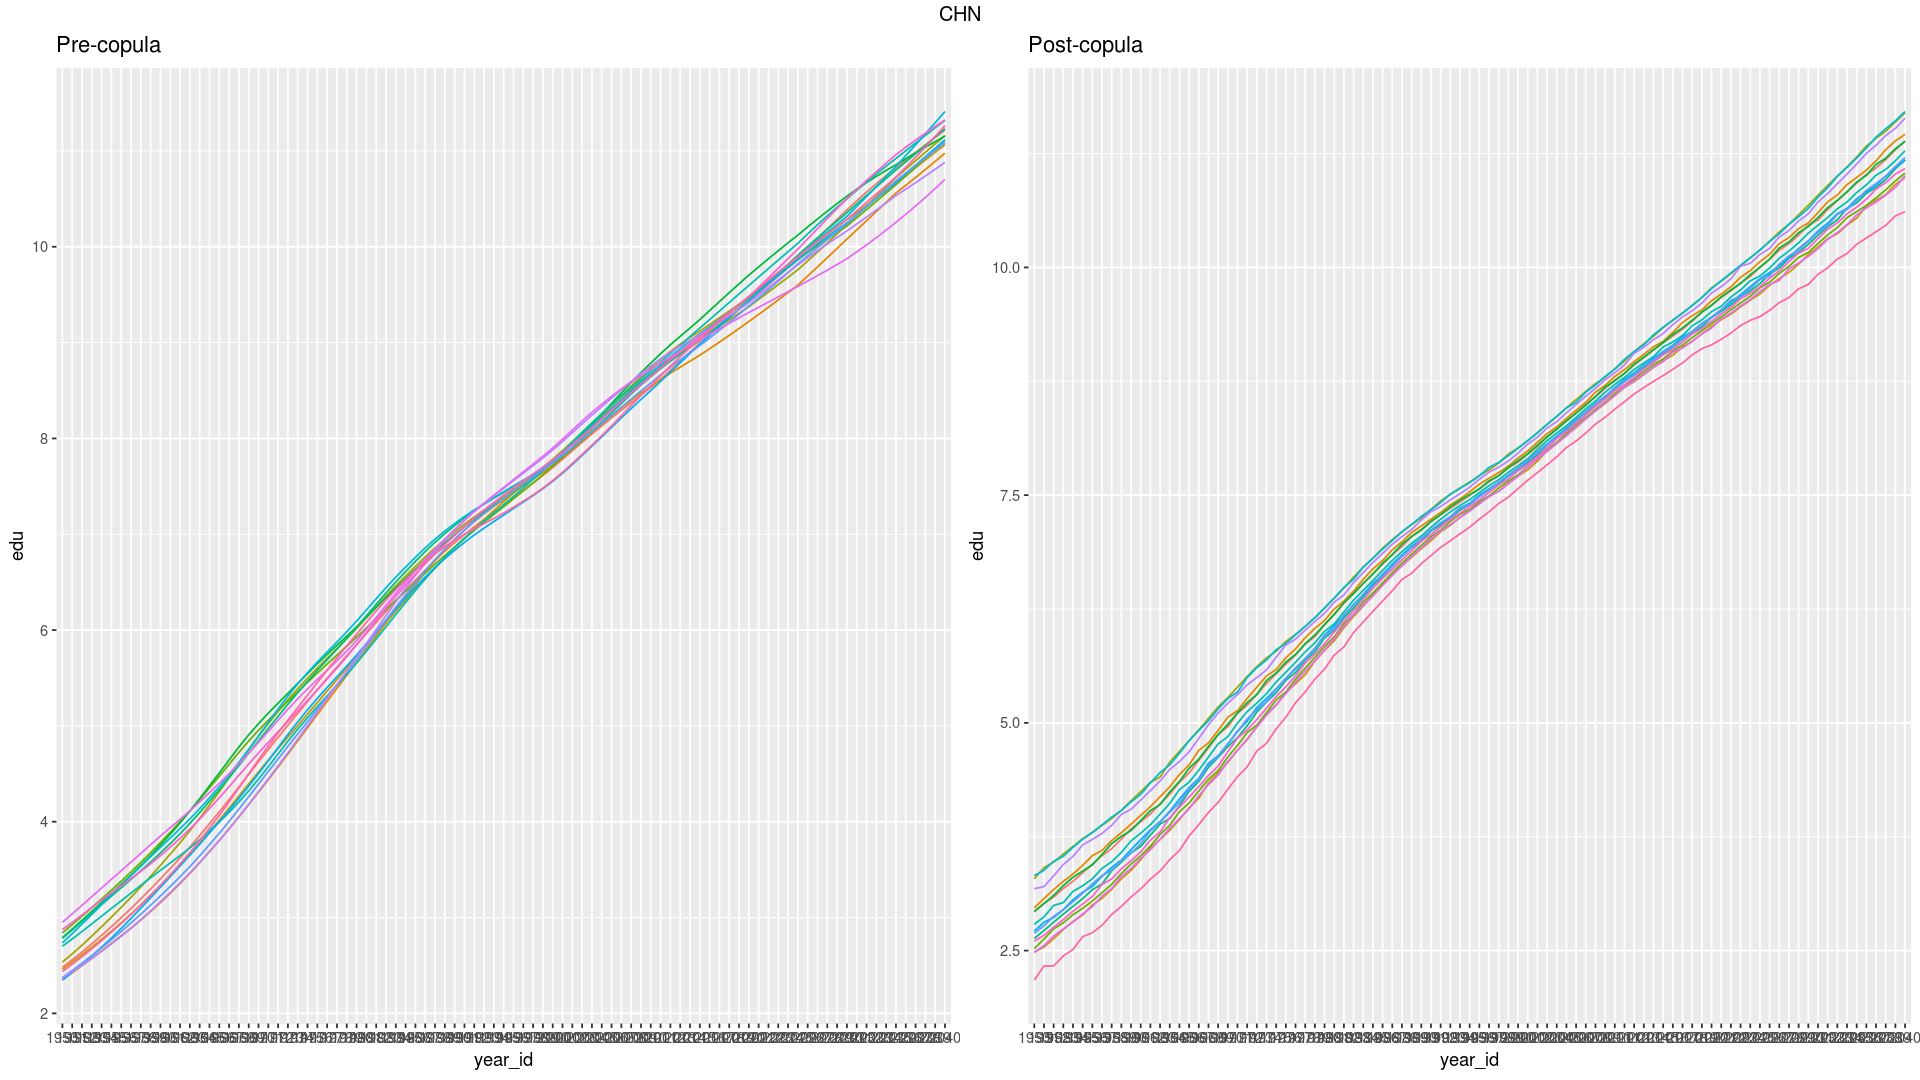

In [76]:
## Plot objects
pre_copula<-ggplot() +
  geom_line(data = melt_pre, aes(x= year_id, y = edu, group= variable,color = variable)) + 
theme(legend.position = "none") + ggtitle("Pre-copula")

post_copula<-ggplot() +
  geom_line(data = melt_post, aes(x= year_id, y = edu, group= variable,color = variable)) + 
theme(legend.position = "none") + ggtitle("Post-copula")

grid.arrange(pre_copula, post_copula, ncol=2, top = paste0(isoiso))

In [ ]:
# create_sorted_data <- function(y1_vect = y1_vect,
                               
#                                # Baseline casted data frame
#                                cast_data = dcast1,  
                               
#                                # Post Copula data frame
#                                post_copula = post_copula,
                               
#                                # Index of draws from cast data
#                                draw_index = dcast1$variable,
                               
#                                rho = 0.9, draws = N_draws) {

#     ## Length of year vectors
#     dims <- length(y1_vect)
    
#     ## Base year vectors (year vector minus 1)
#     y2_vect <- y1_vect - 1
    

#     for(yr in 1:dims) {

#         ## Simulate bivariate uniform distribution with a specified correlation

#         # Create a normal copula object with the rho
#         norm.cop <- normalCopula(rho, dim = 2, dispstr = "un")

#         # Create the distribution from the copula object
#         X <- rCopula(N_draws, norm.cop)


#         # Convert the simulated copula to be on the support of number of draws   
#         X1_sorts <- data.frame(index = ceiling(X[,1]*N_draws))
#         X2_sorts <- data.frame(index = ceiling(X[,2]*N_draws))


#         # Bounding if any value is above the highest number of draws 
#         X1_sorts[,1] <- ifelse(X1_sorts[,1]>N_draws, N_draws, X1_sorts[,1])
#         X2_sorts[,1] <- ifelse(X2_sorts[,1]>N_draws, N_draws, X2_sorts[,1])


#         # Check Spearman value
#         cor(X1_sorts,X2_sorts, method="spearman")

#         ## Create joint ranks
#         joint <- cbind.data.frame(X1_sorts, X2_sorts)
#         colnames(joint) <- c("ind1", "ind2")
#         joint <- arrange(joint, ind2)


#         y1 = as.character(y1_vect[yr])
#         y2 = as.character(y2_vect[yr])

#         print(paste0("Step: ", yr))
        
#         print(paste0("Year set as base: " ,y2))
#         print(paste0("Year to be sorted: " ,y1))



#         ## Take the two years, and take them out as vectors    
#         unsorted_draws_TOSORT <- data.frame( tosort =   cast_data[, paste0(y1)] , index = draw_index)

#         if (yr == 1) {
#           unsorted_draws_BASE <- data.frame(  base = cast_data[, paste0(y2)] , index = draw_index) 
#         }
#         if (yr > 1) {
#           unsorted_draws_BASE <- data.frame(  base = post_copula[, paste0("t",y2)] , index = draw_index) 

#         }


#         zero_X1 <- matrix(rep(0, dim(joint)[1]))
#         zero_X2 <- matrix(rep(0, dim(joint)[1]))


#         # Pre correlation value
#         cor(unsorted_draws_TOSORT$tosort, unsorted_draws_BASE$base, method="spearman")

#         # Sort our draws
#         ordered_draws_tosort <- arrange(unsorted_draws_TOSORT, tosort )
#         ordered_draws_base <- arrange(unsorted_draws_BASE, base )




#     ## Reference year data
#         ## Take these ordered draws, create a new vector, and use indices of X1_sorts to reshuffle the data:      
#           coptd_base <- vector()

#           j = 0

#           for(i in joint[,2]) {
#             j = j + 1
#             coptd_base[j] = ordered_draws_base[i,1]
#           }


#           coptd_base <- data.frame(coptd_base)
#           colnames(coptd_base)[1] <- paste0("t",y2)



#           colnames(unsorted_draws_BASE)[1] <- paste0("t",y2)


#     ## To-be-sorted year data    
#         ## Now, we have to merge back the draw indices         
#           coptd_tosort <- vector()

#           j = 0
#           for(i in joint[,1]) {
#             j = j + 1
#             # print(paste0("Row ",j ," with row ", i))

#             coptd_tosort[j] = ordered_draws_tosort[i,1]
#           }



#         coptd_tosort <- data.frame(coptd_tosort)
#         colnames(coptd_tosort)[1] <- paste0("t",y1)


#         colnames(unsorted_draws_TOSORT)[1] <- paste0("t",y1)


#        ## Do some intermediate graphing to check status 
#         # par(mfrow=c(1,2),oma = c(0, 0, 2, 0))
#         # plot(unsorted_draws_TOSORT[,1], unsorted_draws_BASE[,1], main = "before sorting")
#         # plot(coptd_tosort[,1] , coptd_base[,1] , main = "After sorting using Gaussian copula")
#         # mtext("Target rho from 2025-2040 ", outer = TRUE, cex = 1.5)



#         ## Column bind the newly mapped draws
#         copt_bind <- cbind.data.frame(coptd_base, coptd_tosort)
#         post_copula <- cbind.data.frame(post_copula, copt_bind[,2])


#         # post_copula <- cbind.data.frame(post_copula,  to_sub[,2])
#         colnames(post_copula)[dim(post_copula)[2]] <- paste0("t",y1)


#         # What's our new rho?
#         print(paste0("New Rho: ", cor(coptd_tosort[,1], coptd_base[,1], method="spearman")))



#       }

#     return(post_copula)
    
#     }

In [78]:
# post_2 <- create_sorted_data(y1_vect = y1_vect, 
#                              cast_data = dcast1,  
#                              post_copula = post_copula, 
#                              draw_index = dcast1$variable,
#                              rho = mean_rho, 
#                              draws = N_draws)

In [28]:
# new_cast_col <- c(paste0("t",c(2016:2040)), paste0(c(1950:2015)))
# new_cast_colNames <- c("ihme_loc_id", "location_id", "variable", c(2016:2040))

# dcast_copula <- post_2[,c("ihme_loc_id", "location_id", "variable", new_cast_col)]
# colnames(dcast_copula) <- new_cast_colNames
# dcast2_copula <- cbind(dcast_copula[, c("ihme_loc_id", "location_id")], dcast_copula[,paste0(c(2016:2040))])

# dcast2_copula$variable <- paste0("draw_", c(1:N_draws))

# melt2 <- melt(dcast2_copula, id.vars=c("ihme_loc_id", "location_id", "variable"))
# colnames(melt2) <- c("ihme_loc_id", "location_id", "variable", "year_id", "edu")

# dcast2 <- dcast(melt2, value.var = "edu", ihme_loc_id + location_id + year_id ~ variable)
# dcast2$year <- as.numeric(dcast2$year) + 2015
# dcast2 <- dcast2[ ,c("ihme_loc_id", "location_id", "year_id",paste0("draw_", c(1:N_draws)))]

In [34]:
# ## Pre copula data
# melt_pre <- melt(dcast1, id.vars=c("ihme_loc_id", "location_id", "variable"), value.name = "edu")
# colnames(melt_pre)[4] <- "year_id"
# melt_pre <- dcast(melt_pre, value.var = "edu", ihme_loc_id + location_id + year_id ~ variable )

# ## Vector of random draws
# samp_colnames <- c("ihme_loc_id", "year_id", paste0("draw_",sample(N_draws, size = 15)))

# ## Subset out each of the 
# melt_pre <- melt_pre[,samp_colnames]

# ## Post copula data
# melt_post <- dcast2[,samp_colnames]

# ## Melt the data post-sampling
# melt_pre <- melt(melt_pre, id.vars = c("ihme_loc_id", "year_id"), value.name = "edu")
# melt_pre$year <- as.numeric(melt_pre$year) + 2015
# melt_post <- melt(melt_post, id.vars = c("ihme_loc_id", "year_id"), value.name = "edu")


In [77]:
# ## Plot objects
# pre_copula<-ggplot() +
#   geom_line(data = melt_pre, aes(x= year_id, y = edu, group= variable,color = variable)) + 
# theme(legend.position = "none") + ggtitle("Pre-copula")

# post_copula<-ggplot() +
#   geom_line(data = melt_post, aes(x= year_id, y = edu, group= variable,color = variable)) + 
# theme(legend.position = "none") + ggtitle("Post-copula")

# grid.arrange(pre_copula, post_copula, ncol=2, top = paste0(isoiso))

In [41]:
# Pre stats
pre_stats <- cbind(country_sub[, c("location_id", "year_id")], 
                     rowMeans(country_sub[, grep(glob2rx("draw_*"), names(country_sub))], na.rm = TRUE, dims = 1), 
                     t(apply(country_sub[, grep(glob2rx("draw_*"), names(country_sub))],1,quantile,probs=c(0.025, 0.975),na.rm=TRUE)))
colnames(pre_stats) <- c("location_id", "year_id", "mean", "lower","upper")


In [43]:
# Post stats
post_stats <- cbind(dcast2[, c("location_id", "year_id")], 
                     rowMeans(dcast2[, grep(glob2rx("draw_*"), names(dcast2))], na.rm = TRUE, dims = 1), 
                     t(apply(dcast2[, grep(glob2rx("draw_*"), names(dcast2))],1,quantile,probs=c(0.025, 0.975),na.rm=TRUE)))
colnames(post_stats) <- c("location_id", "year_id", "mean", "lower","upper")


In [48]:
head(cbind.data.frame(subset(pre_stats, year_id>2015),post_stats))

,location_id,year_id,mean,lower,upper,location_id,year_id,mean,lower,upper
67,6,2016,9.115617,8.900029,9.343116,6,2016,9.113266,8.912300,9.334140
68,6,2017,9.191124,8.971018,9.420748,6,2017,9.189264,8.968714,9.457412
69,6,2018,9.267322,9.037832,9.505786,6,2018,9.271514,9.046433,9.502691
70,6,2019,9.344145,9.103606,9.589633,6,2019,9.341553,9.084523,9.589559
71,6,2020,9.421529,9.171828,9.685982,6,2020,9.423678,9.174082,9.692607
72,6,2021,9.498742,9.242905,9.775997,6,2021,9.492706,9.241054,9.777498
